# Comparing Classification Models

We want to compare various classification models for the customer dataset. We'll look at logistic regression, LDA, QDA, and $k$-nearest neighbors.

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# We'll look at logistic regression, LDA, QDA, and KNN
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

# Need to import tree stuff
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz, export_text, plot_tree

# Ensemble methods for trees
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

# We'll standardize and split data into training/testing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# import RFECV class
from sklearn.feature_selection import RFECV

# Need to measure "goodness"
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, average_precision_score, precision_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

In [2]:
# Read in the data and print out its shape
cust = pd.read_csv('./data/customers_clean.csv')
print(cust.shape)

(12266, 11)


In [3]:
# Let's drop the following columns:
# cust_id, join_date, last_purchase_date
new_cust = cust.drop(columns=['cust_id','join_date','last_purchase_date'])
new_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12266 entries, 0 to 12265
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            12266 non-null  object
 1   age               12266 non-null  int64 
 2   marital_status    12266 non-null  object
 3   household_income  12266 non-null  int64 
 4   home_ownership    12266 non-null  object
 5   num_children      12266 non-null  int64 
 6   num_vehicles      12266 non-null  int64 
 7   spend             12266 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 766.8+ KB


In [4]:
# Create dummies and save in new DataFrame
data = pd.get_dummies(new_cust, dtype=int, drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12266 entries, 0 to 12265
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   age                       12266 non-null  int64
 1   household_income          12266 non-null  int64
 2   num_children              12266 non-null  int64
 3   num_vehicles              12266 non-null  int64
 4   spend                     12266 non-null  int64
 5   gender_M                  12266 non-null  int64
 6   marital_status_unmarried  12266 non-null  int64
 7   home_ownership_rent       12266 non-null  int64
 8   home_ownership_unknown    12266 non-null  int64
dtypes: int64(9)
memory usage: 862.6 KB


## Create "big spender"

We want to convert the $y$ variable, `spend`, into a binary variable where 1 represents a big spender and a 0 otherwise. We can set the cutoff anywhere we want. Looking at the summary statistics from above, let's use \$5,700 (because I don't like you) as the cutoff. We can use the function `pd.cut()`.

In [5]:
data['big_spender'] = pd.cut(data.spend, bins=[0,5700,10000], right=True, labels=[0,1]).astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12266 entries, 0 to 12265
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   age                       12266 non-null  int64
 1   household_income          12266 non-null  int64
 2   num_children              12266 non-null  int64
 3   num_vehicles              12266 non-null  int64
 4   spend                     12266 non-null  int64
 5   gender_M                  12266 non-null  int64
 6   marital_status_unmarried  12266 non-null  int64
 7   home_ownership_rent       12266 non-null  int64
 8   home_ownership_unknown    12266 non-null  int64
 9   big_spender               12266 non-null  int64
dtypes: int64(10)
memory usage: 958.4 KB


In [6]:
# See summary statistics
data.describe()

,age,household_income,num_children,num_vehicles,spend,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown,big_spender
count,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000
mean,37.864096,301670.381135,2.505544,2.503913,4531.936736,0.315669,0.251834,0.252323,0.101582,0.255421
std,10.663234,115752.377718,1.707281,1.697419,1597.594658,0.464801,0.434084,0.434364,0.302110,0.436116
min,20.000000,65003.000000,0.000000,0.000000,1468.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,217028.250000,1.000000,1.000000,3237.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,307364.500000,3.000000,3.000000,4766.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,47.000000,399456.250000,4.000000,4.000000,5723.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,56.000000,489982.000000,5.000000,5.000000,7500.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Split Data into Training and Test Sets

Need to first define `X` and `y`. Then we can try train/test split.

In [7]:
# define the output variable, y
y = data.big_spender

# define the X
# Notice this time we are only dropping the original 'spend'
# and the 'big_spender' columns.
X = data.drop(columns=['spend', 'big_spender'])

In [8]:
# Time to split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=163)

In [9]:
# What is the percentage of big spenders in both training and test?
print(f'Training percentage of big spenders is {y_train.mean():.2%}')
print(f'Testing percentage of big spenders is  {y_test.mean():.2%}')

Training percentage of big spenders is 25.30%
Testing percentage of big spenders is  26.53%


## Scale the Data

Fit only on the training set. Use that fit to transform both the training and test sets.

In [10]:
# Fit the scaler on just the training X variables
# Let's start with StandardScaler which will center
# each variable at 0 and give each a unit variance (=1)
s_scaler = StandardScaler().fit(X_train)
s_scaler

StandardScaler()

In [11]:
# Transform X_train and put in DataFrame
X_train_ss = pd.DataFrame(s_scaler.transform(X_train), columns=X_train.columns)

# Take a look at the DataFrame
X_train_ss.describe()

,age,household_income,num_children,num_vehicles,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown
count,9.812000e+03,9.812000e+03,9.812000e+03,9.812000e+03,9.812000e+03,9.812000e+03,9.812000e+03,9.812000e+03
mean,4.924267e-17,-1.578662e-16,-6.626035e-17,-9.486455e-17,-4.127694e-17,6.752763e-17,-5.630320e-17,-1.375898e-17
std,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00
min,-1.668967e+00,-2.053426e+00,-1.469745e+00,-1.479061e+00,-6.788013e-01,-5.795470e-01,-5.842546e-01,-3.310260e-01
25%,-8.273933e-01,-7.266243e-01,-8.831620e-01,-8.884476e-01,-6.788013e-01,-5.795470e-01,-5.842546e-01,-3.310260e-01
50%,1.418062e-02,4.409943e-02,2.900033e-01,2.927784e-01,-6.788013e-01,-5.795470e-01,-5.842546e-01,-3.310260e-01
75%,8.557545e-01,8.439403e-01,8.765859e-01,8.833914e-01,1.473185e+00,1.725486e+00,1.711583e+00,-3.310260e-01
max,1.697328e+00,1.642012e+00,1.463169e+00,1.474004e+00,1.473185e+00,1.725486e+00,1.711583e+00,3.020911e+00


In [12]:
# Transform X_test and put in DataFrame
X_test_ss = pd.DataFrame(s_scaler.transform(X_test), columns=X_test.columns)
X_test_ss.describe()

,age,household_income,num_children,num_vehicles,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown
count,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000
mean,0.007360,0.022660,-0.000181,-0.001084,0.002573,0.004695,-0.024796,0.047330
std,0.985393,1.032056,1.007286,1.012526,1.001222,1.002880,0.985813,1.060911
min,-1.668967,-2.051661,-1.469745,-1.479061,-0.678801,-0.579547,-0.584255,-0.331026
25%,-0.827393,-0.746133,-0.883162,-0.888448,-0.678801,-0.579547,-0.584255,-0.331026
50%,0.014181,0.098260,0.290003,-0.002528,-0.678801,-0.579547,-0.584255,-0.331026
75%,0.855755,0.898707,0.876586,0.883391,1.473185,1.725486,-0.584255,-0.331026
max,1.697328,1.641855,1.463169,1.474004,1.473185,1.725486,1.711583,3.020911


# Function to Look at Different Models

I have write a custom function that will take in different models (classifiers) and compute the different metrics so we can compare the different classifiers easily.

In [13]:
# define our function
def modelMetrics(classifier, name, X_test, y_test):
    """
    We want to see how the different models react to the same 
    dataset. We should capture multiple metrics for each model.
    
    classifier: the classifier we are capturing metrics for
    
    name: give it a descriptive name
    
    X_test: the X array for the test set
    
    y_test: the output variable (actual) for test set
    """
    retVal = {}
    
    metrics = {}
    predictions = classifier.predict(X_test)
    metrics['a_score'] = accuracy_score(y_test, predictions)
    metrics['r_score'] = recall_score(y_test, predictions)
    metrics['p_score'] = precision_score(y_test, predictions)
    metrics['f1_score'] = f1_score(y_test, predictions)
    metrics['f2_score'] = fbeta_score(y_test, predictions, beta=2)
    metrics['f0.5_score'] = fbeta_score(y_test, predictions, beta=0.5)
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    totPositives = y_test.sum()
    totNegatives = len(y_test) - totPositives
    
    # Error rate negatives = false positives / total negatives
    metrics['errorNegatives'] = fp/totNegatives
    # Accuracy for negatives = true negatives / total negatives
    metrics['accNegatives'] = tn/totNegatives
    # Error rate for positives = false negatives / total positives
    metrics['errorPositives'] = fn/totPositives
    # Accuracy for positives = true positives / total positives
    metrics['accPositives'] = tp/totPositives

    metrics['roc_auc_score'] = roc_auc_score(y_test,
                                             classifier.predict_proba(X_test)[:,1])
    metrics['avg_p_score'] = average_precision_score(y_test,
                                                     classifier.predict_proba(X_test)[:,1])
    
    retVal[name] = metrics
    
    return pd.DataFrame(retVal)

# Create a Logistic Model

We will use the scaled data and include all the features.

In [14]:
# Create a LogisticRegression
logReg = LogisticRegression()

# fit the logistic regression model
logReg.fit(X_train_ss, y_train)

LogisticRegression()

In [15]:
# Print out the estimated intercept and coefficients
print(logReg.intercept_)
print(logReg.coef_)

[-1.56122424]
[[ 0.01351489  1.49432465  0.05470842 -0.02827117 -0.00178064  0.00337056
   0.06080097  0.02693605]]


In [16]:
# Get the model metrics using user-defined function
lr_metrics = modelMetrics(logReg, 'logistic regression', X_test_ss, y_test)
lr_metrics

,logistic regression
a_score,0.773839
accNegatives,0.886301
accPositives,0.462366
avg_p_score,0.571773
errorNegatives,0.113699
...,...
f1_score,0.520311
f2_score,0.483923
p_score,0.594862
r_score,0.462366


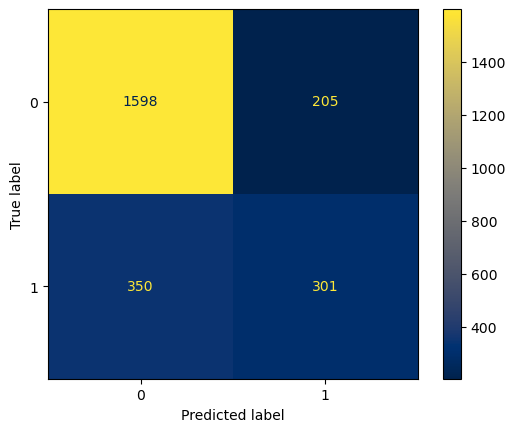

In [17]:
# Let's make a plot of confusion matrix
ConfusionMatrixDisplay.from_estimator(logReg, X_test_ss, y_test, cmap='cividis')

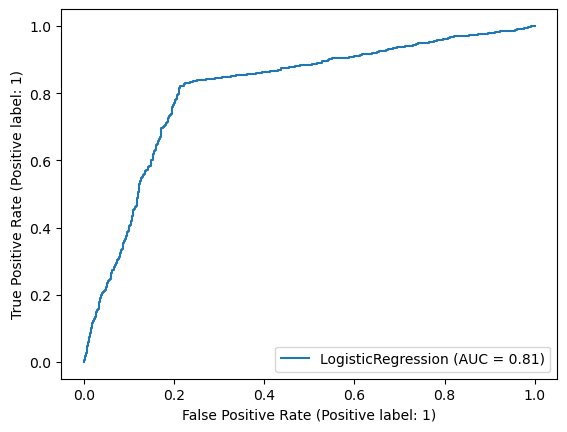

In [18]:
# Create an ROC Curve display
RocCurveDisplay.from_estimator(logReg, X_test_ss, y_test)

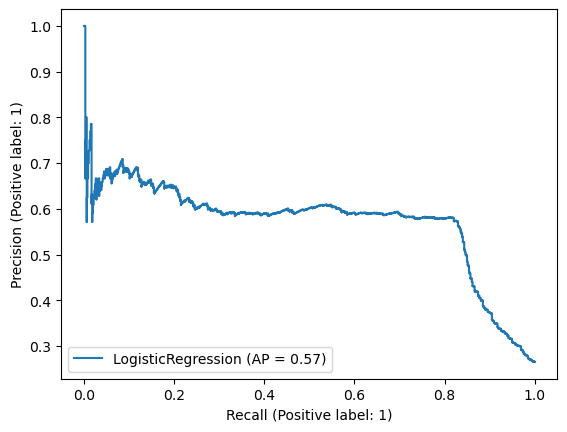

In [19]:
# Make a Precision Recall display
PrecisionRecallDisplay.from_estimator(logReg, X_test_ss, y_test)

## Logistic Regression CV

We can use `LogisticRegressionCV` to regularize the coefficients on the input variables to attempt to get a better model.

In [20]:
from sklearn.linear_model import LogisticRegressionCV

In [21]:
logRegCV = LogisticRegressionCV().fit(X_train_ss, y_train)

In [22]:
logRegCV_metrics = modelMetrics(logRegCV, 'logistic regression CV', X_test_ss, y_test)
logRegCV_metrics

,logistic regression CV
a_score,0.773431
accNegatives,0.885746
accPositives,0.462366
avg_p_score,0.571794
errorNegatives,0.114254
...,...
f1_score,0.519862
f2_score,0.483767
p_score,0.593688
r_score,0.462366


## Recursive Feature Elimination

We can also use `RFECV` on a `LogisticRegression` to find the smallest set of input variables for a model. Let's try it with logistic regression

In [23]:
logReg_rfecv = LogisticRegression()
rfecv = RFECV(logReg_rfecv)

In [24]:
logReg_rfecv.fit(rfecv.fit_transform(X_train_ss, y_train), y_train)

LogisticRegression()

In [25]:
rfecv.n_features_

1

In [26]:
rfecv.ranking_

array([6, 1, 3, 4, 8, 7, 2, 5])

In [27]:
X_train_ss.columns

Index(['age', 'household_income', 'num_children', 'num_vehicles', 'gender_M',
       'marital_status_unmarried', 'home_ownership_rent',
       'home_ownership_unknown'],
      dtype='object')

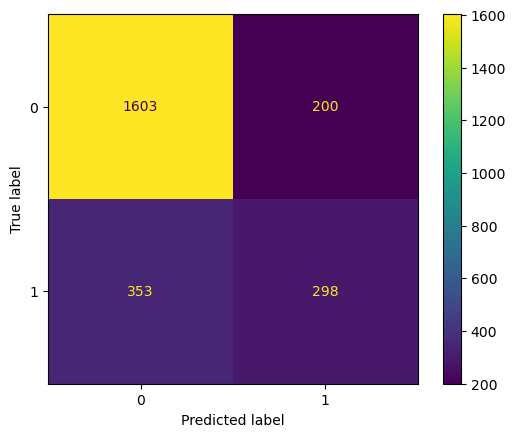

In [28]:
ConfusionMatrixDisplay.from_estimator(rfecv, X_test_ss, y_test)

In [29]:
rfe_metrics = modelMetrics(rfecv, 'RFE logistic regression', X_test_ss, y_test)
rfe_metrics

,RFE logistic regression
a_score,0.774654
accNegatives,0.889074
accPositives,0.457757
avg_p_score,0.569965
errorNegatives,0.110926
...,...
f1_score,0.518712
f2_score,0.480335
p_score,0.598394
r_score,0.457757


# Linear Discriminant Analysis
Let's now try LDA. We already imported the appropriate packages for LDA.

In [30]:
# Create an LDA instance
lda = LinearDiscriminantAnalysis()

In [31]:
# Fit the LDA model with X and y training set created previously
lda.fit(X_train_ss, y_train)

LinearDiscriminantAnalysis()

In [32]:
# Get the model metrics using user-defined function
lda_metrics = modelMetrics(lda, 'LDA', X_test_ss, y_test)
lda_metrics

,LDA
a_score,0.772209
accNegatives,0.884637
accPositives,0.460829
avg_p_score,0.577673
errorNegatives,0.115363
...,...
f1_score,0.517688
f2_score,0.482005
p_score,0.590551
r_score,0.460829


# Quadratic Discriminant Analysis
We can also try QDA (already imported package)

In [33]:
# Create a QDA instance
qda = QuadraticDiscriminantAnalysis()

In [34]:
# Fit the qda with X and y
qda.fit(X_train_ss, y_train)

QuadraticDiscriminantAnalysis()

In [35]:
# Get the model metrics using user-defined function
qda_metrics = modelMetrics(qda, 'QDA', X_test_ss, y_test)
qda_metrics

,QDA
a_score,0.777099
accNegatives,0.873544
accPositives,0.509985
avg_p_score,0.565531
errorNegatives,0.126456
...,...
f1_score,0.548307
f2_score,0.524652
p_score,0.592857
r_score,0.509985


# KNN
Might as well try $k$-nearest neighbors. Let's use $k=3$.

In [36]:
# Let's use k=k
knn = KNeighborsClassifier(n_neighbors=3)

In [37]:
# fit the model
knn.fit(X_train_ss, y_train)

KNeighborsClassifier(n_neighbors=3)

In [38]:
# Get the model metrics using user-defined function
knn3_metrics = modelMetrics(knn, 'KNN-3', X_test_ss, y_test)
knn3_metrics

,KNN-3
a_score,0.766911
accNegatives,0.859678
accPositives,0.509985
avg_p_score,0.465095
errorNegatives,0.140322
...,...
f1_score,0.537217
f2_score,0.520539
p_score,0.567521
r_score,0.509985


## A Simple Decision Tree

In [39]:
dt = DecisionTreeClassifier().fit(X_train_ss, y_train)

In [40]:
dt_metrics = modelMetrics(dt, 'Decision Tree', X_test_ss, y_test)
dt_metrics

,Decision Tree
a_score,0.732681
accNegatives,0.820854
accPositives,0.488479
avg_p_score,0.378031
errorNegatives,0.179146
...,...
f1_score,0.492260
f2_score,0.489985
p_score,0.496100
r_score,0.488479


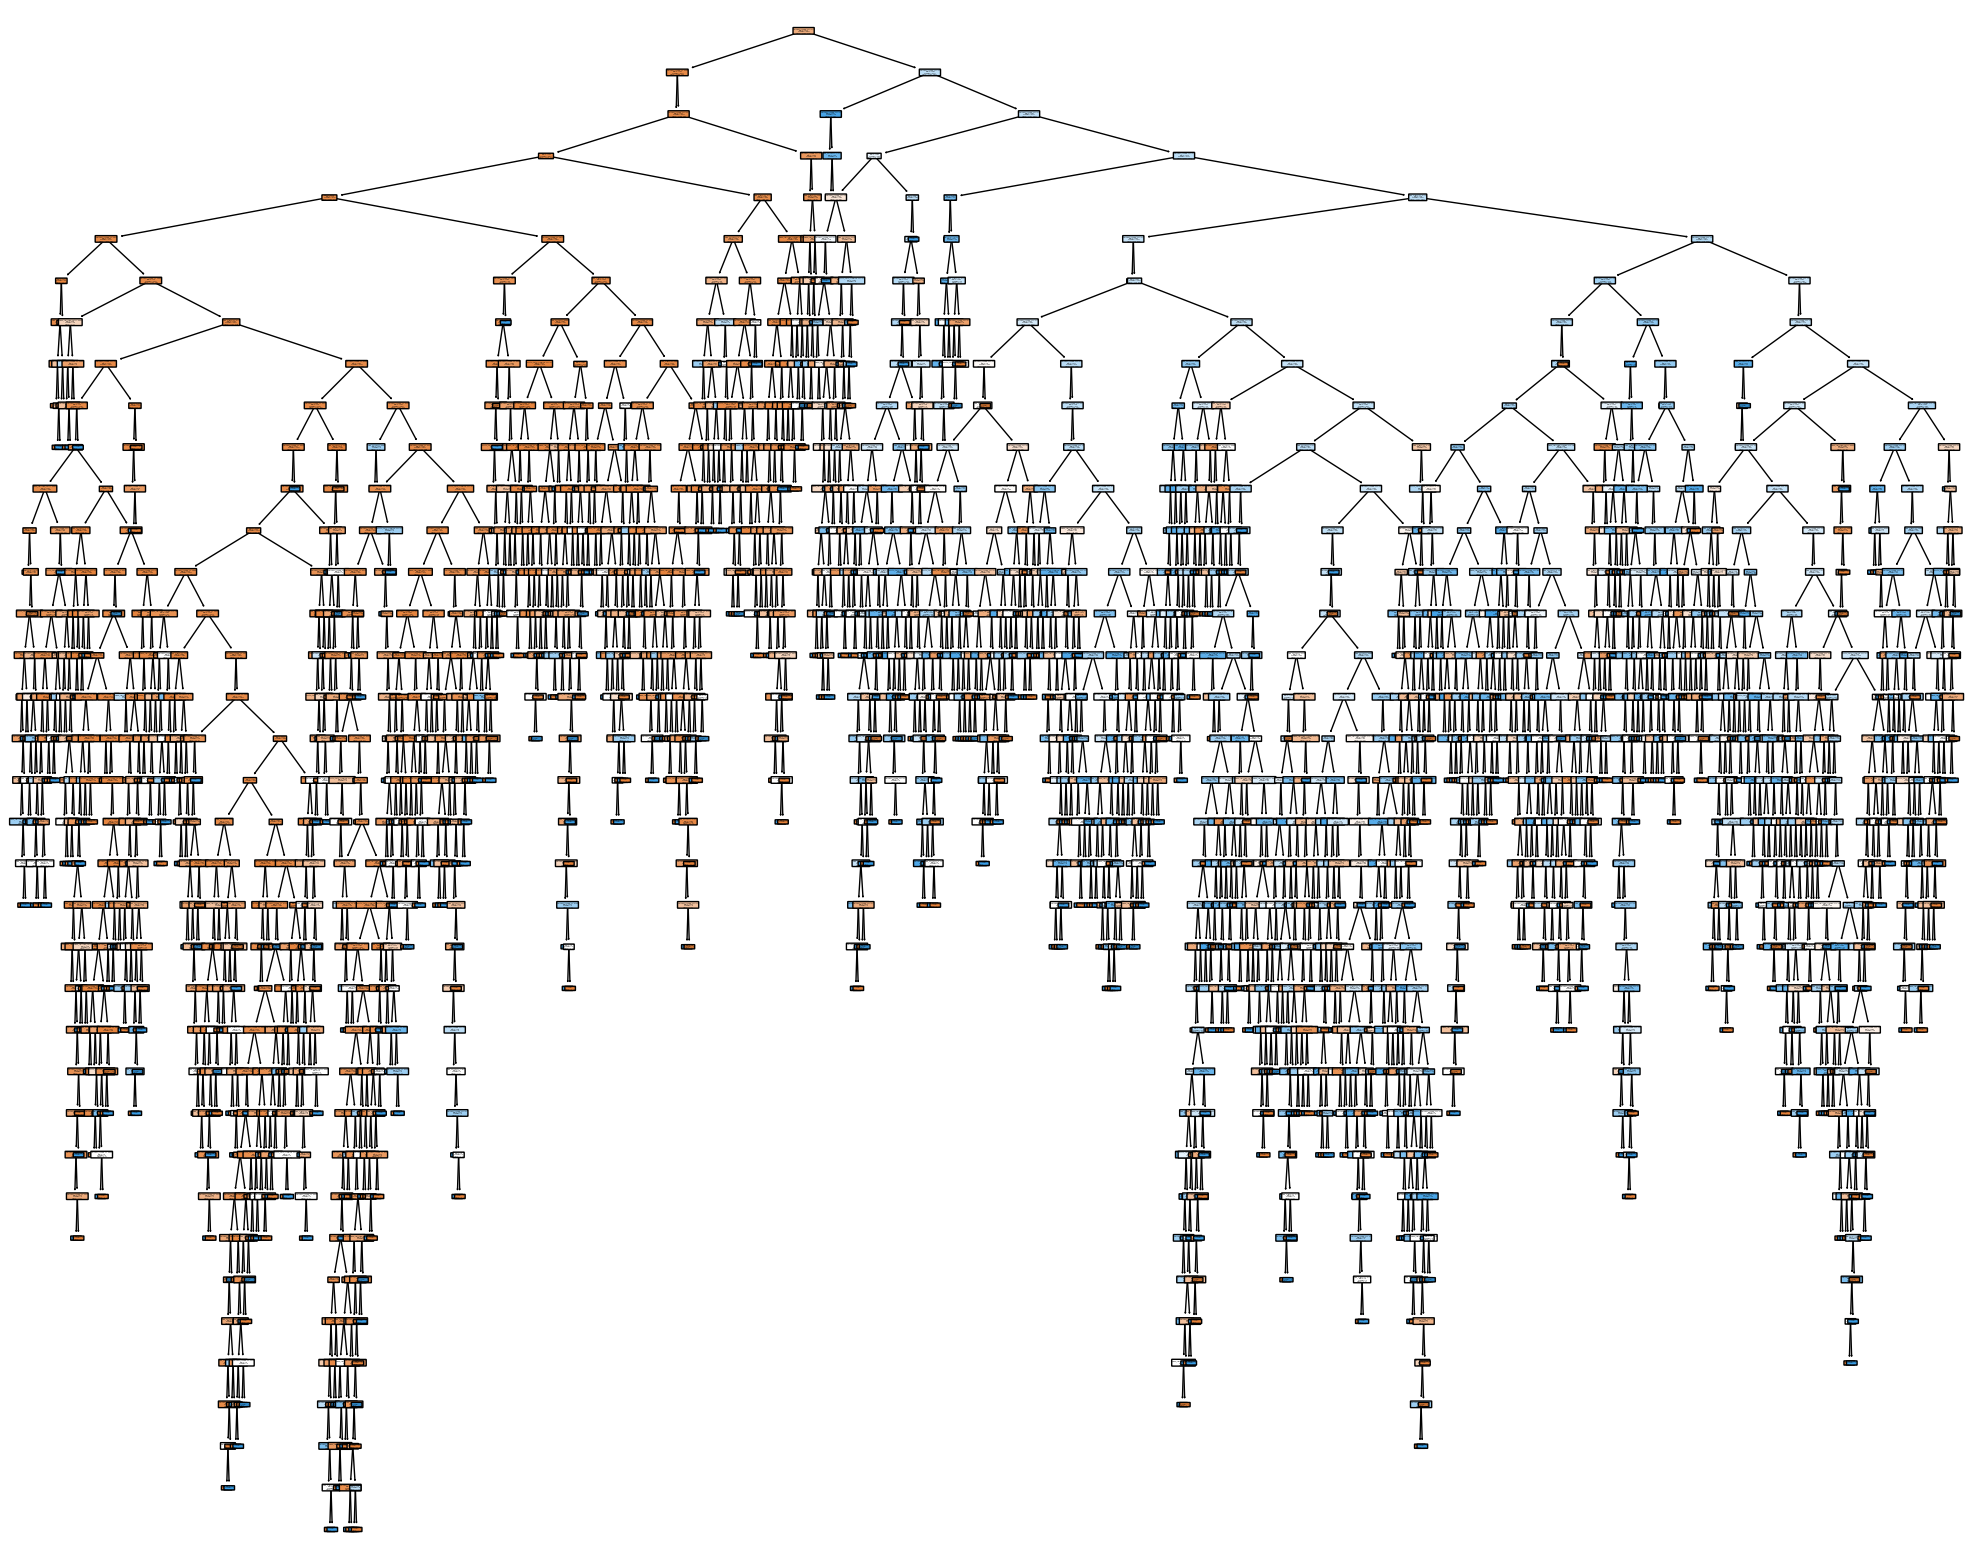

In [41]:
fig = plt.figure(figsize=(25, 20))
plot_tree(dt, feature_names=X.columns, filled=True, rounded=True);

In [42]:
dt3 = DecisionTreeClassifier(max_depth=3, random_state=42)
dt3.fit(X_train_ss, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

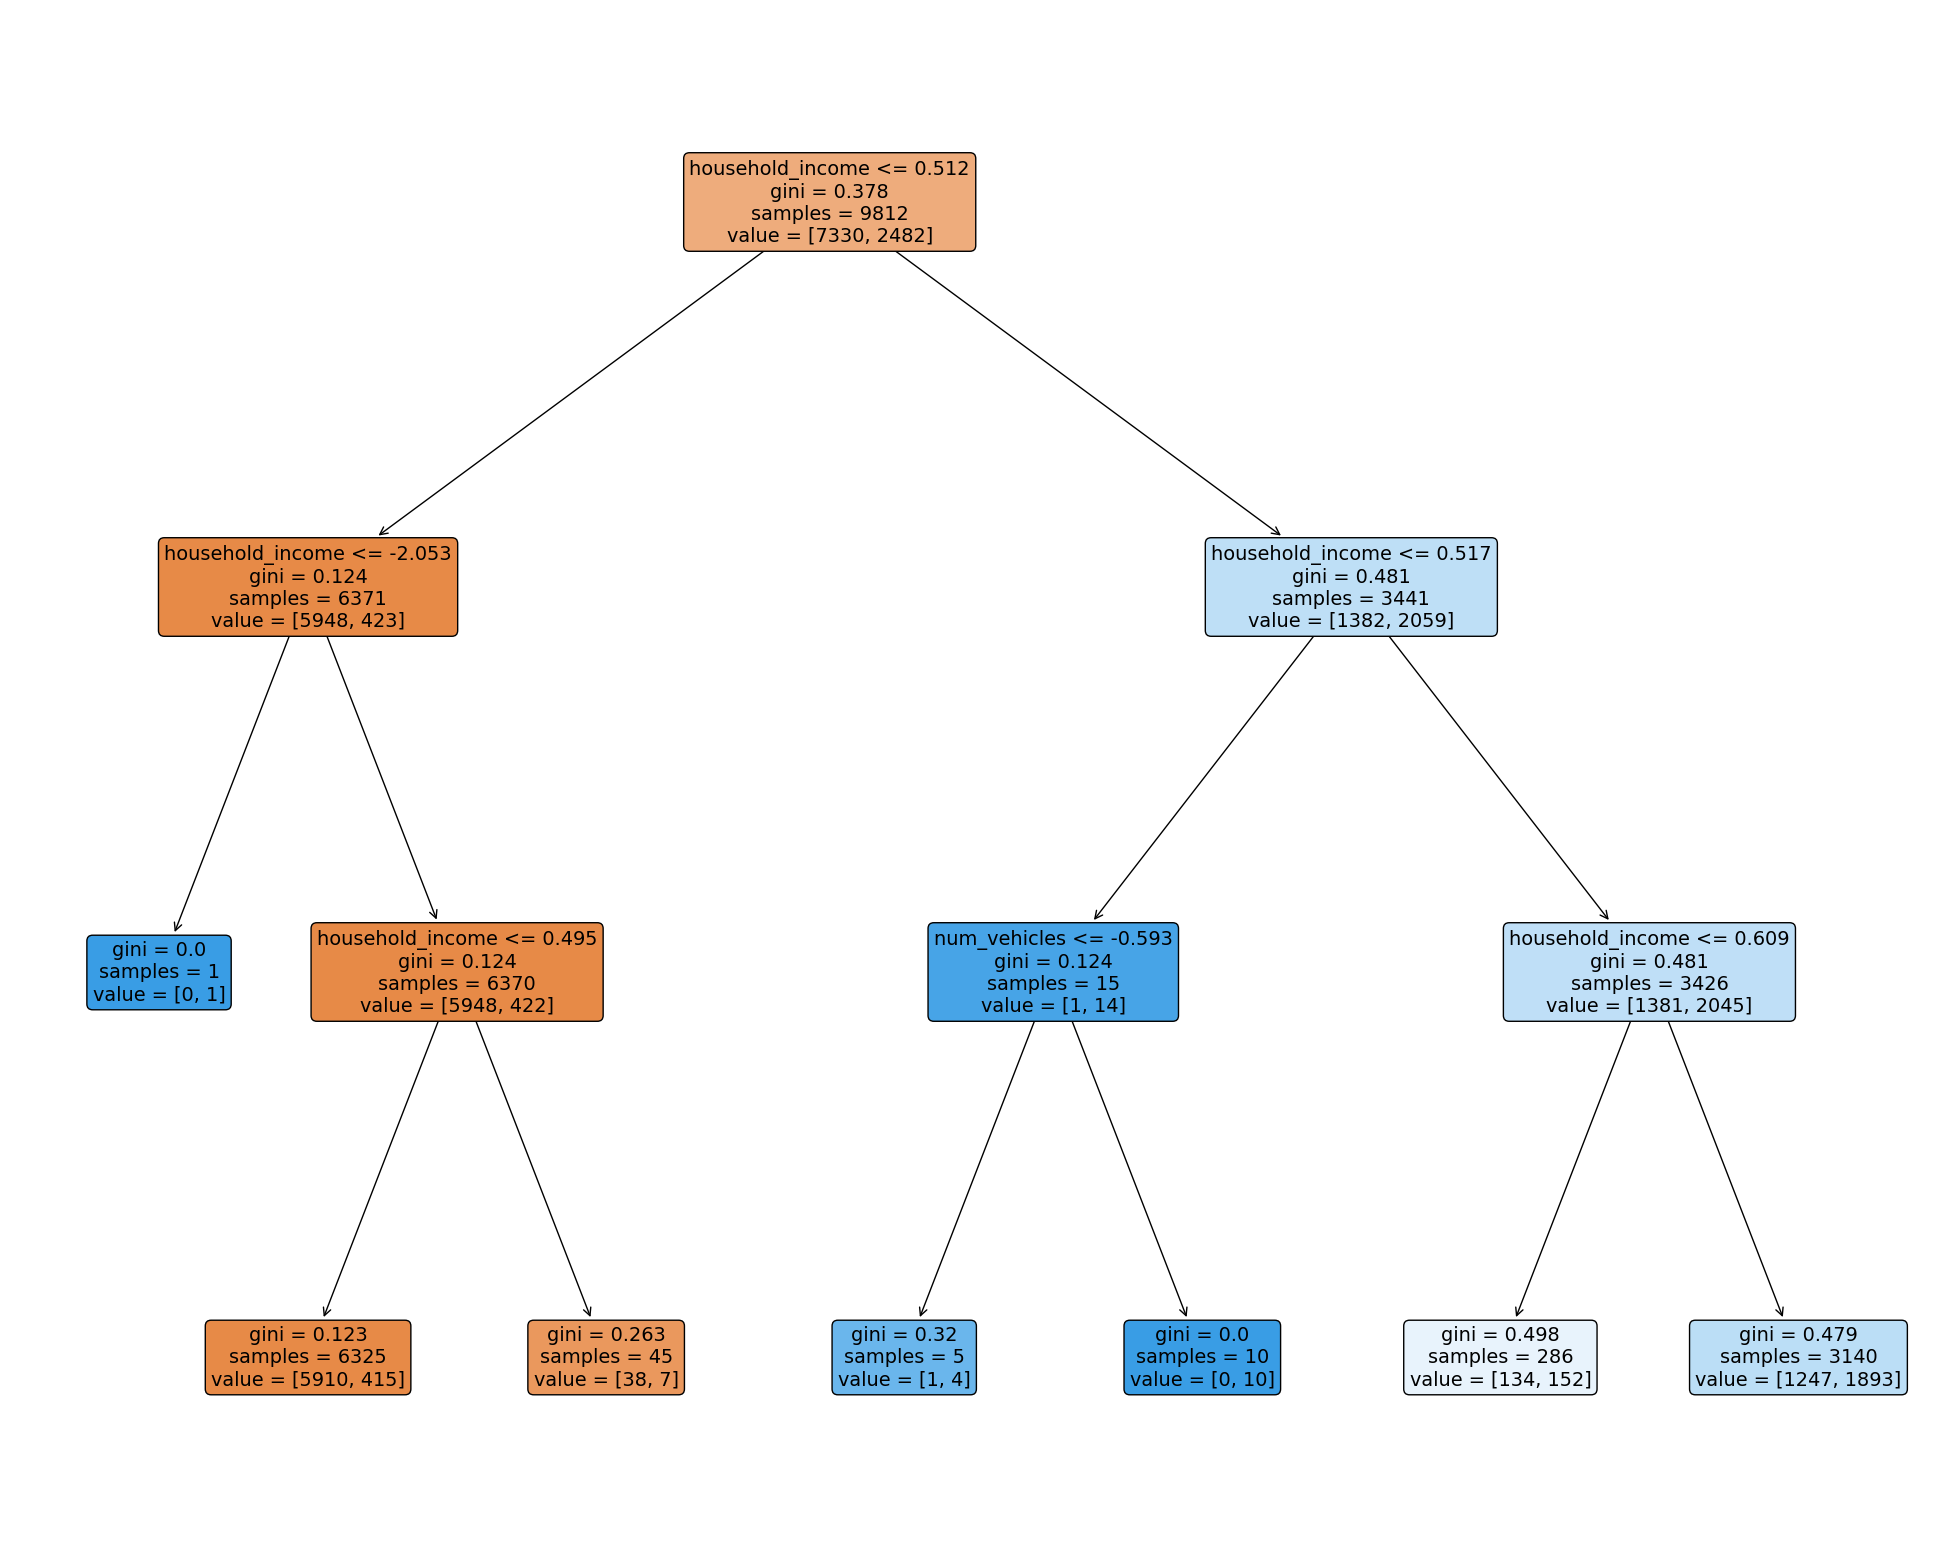

In [43]:
fig = plt.figure(figsize=(25, 20))
plot_tree(dt3, feature_names=X.columns, filled=True, rounded=True);

In [44]:
dt3_metrics = modelMetrics(dt3, 'Decision Tree - 3', X_test_ss, y_test)
dt3_metrics

,Decision Tree - 3
a_score,0.797881
accNegatives,0.787576
accPositives,0.826421
avg_p_score,0.528756
errorNegatives,0.212424
...,...
f1_score,0.684478
f2_score,0.763121
p_score,0.584148
r_score,0.826421


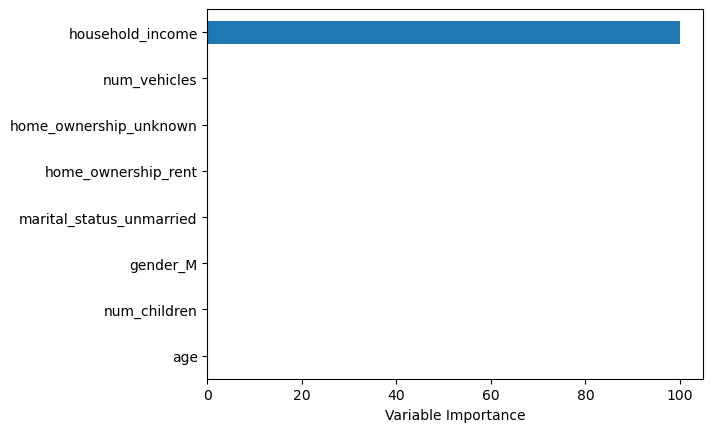

In [45]:
importance = pd.DataFrame({'Importance':dt3.feature_importances_*100},
                          index=X.columns)
importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [46]:
dt6 = DecisionTreeClassifier(max_depth=6, random_state=42)
dt6.fit(X_train_ss, y_train)

DecisionTreeClassifier(max_depth=6, random_state=42)

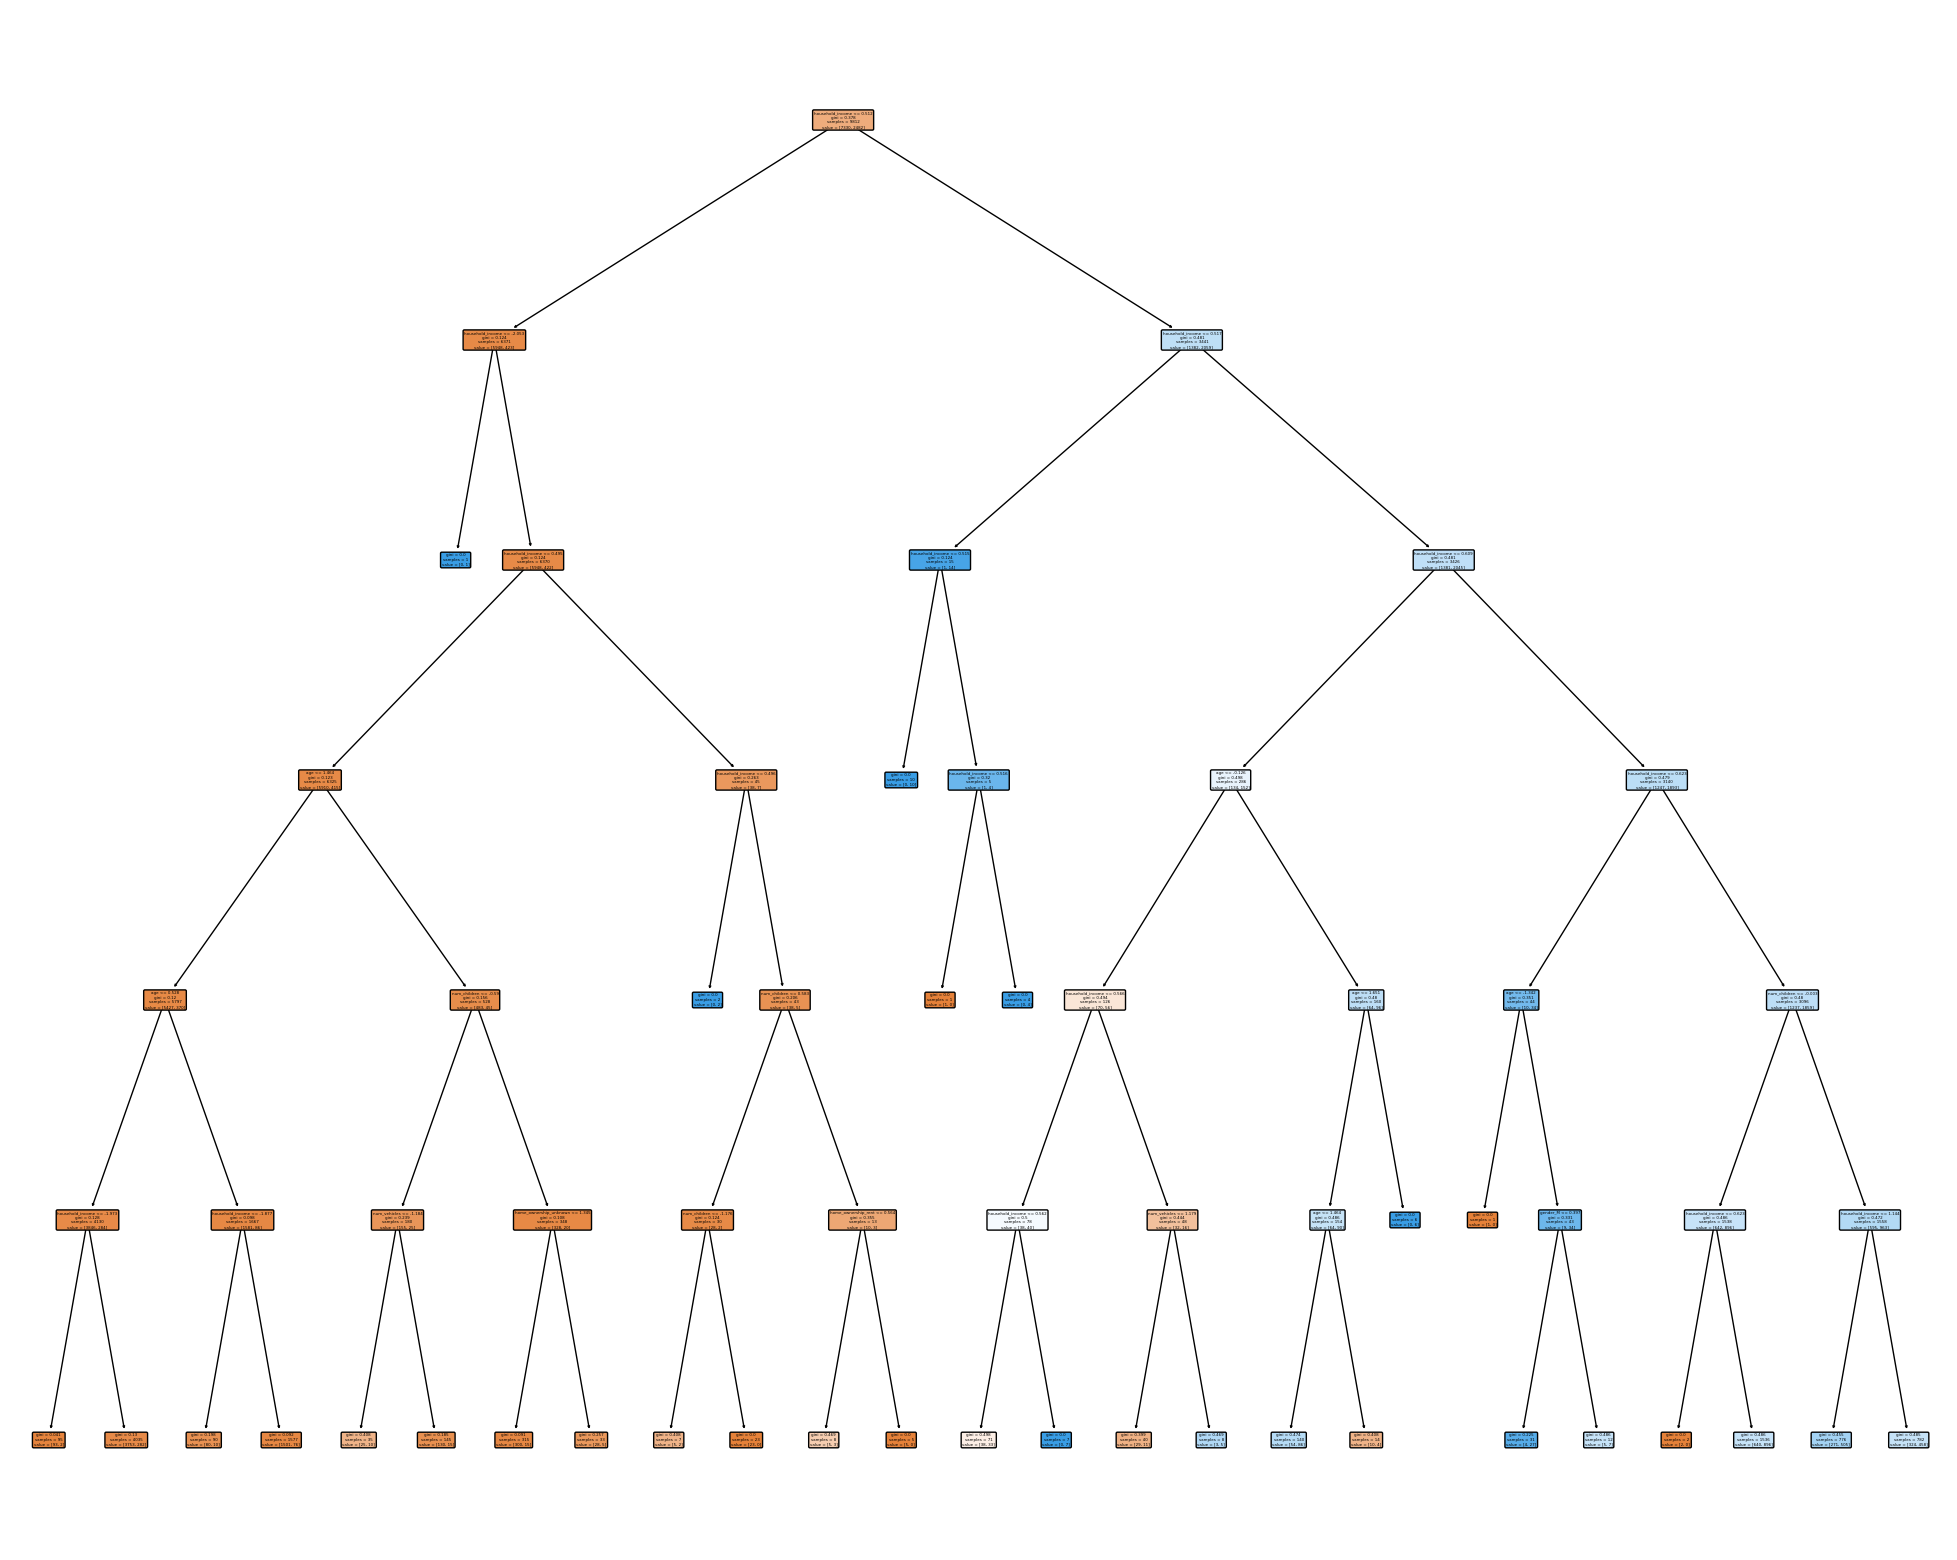

In [47]:
fig = plt.figure(figsize=(25, 20))
plot_tree(dt6, feature_names=X.columns, filled=True, rounded=True);

In [48]:
dt6_metrics = modelMetrics(dt6, 'Decision Tree - 6', X_test_ss, y_test)
dt6_metrics

,Decision Tree - 6
a_score,0.793399
accNegatives,0.794232
accPositives,0.791091
avg_p_score,0.521371
errorNegatives,0.205768
...,...
f1_score,0.670137
f2_score,0.737822
p_score,0.581264
r_score,0.791091


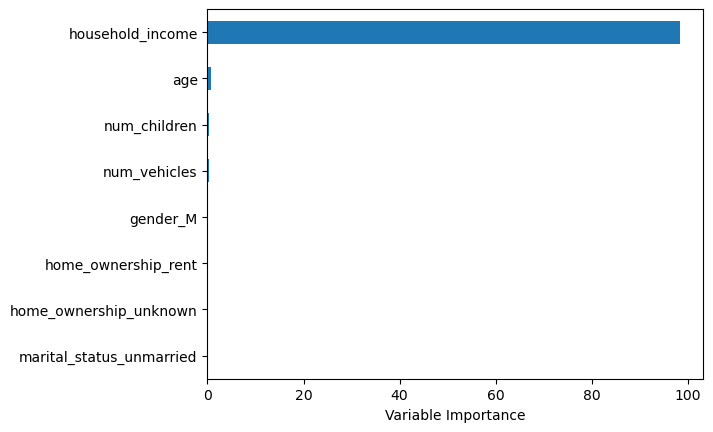

In [49]:
importance = pd.DataFrame({'Importance':dt6.feature_importances_*100},
                          index=X.columns)
importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

## Bagging

In [50]:
bag = BaggingClassifier(random_state=42).fit(X_train_ss, y_train)

In [51]:
bag_metrics = modelMetrics(bag, 'Bagging', X_test_ss, y_test)
bag_metrics

,Bagging
a_score,0.781174
accNegatives,0.873544
accPositives,0.525346
avg_p_score,0.543784
errorNegatives,0.126456
...,...
f1_score,0.560197
f2_score,0.538752
p_score,0.600000
r_score,0.525346


## Random Forest

In [52]:
rf = RandomForestClassifier(random_state=42).fit(X_train_ss, y_train)

In [53]:
rf_metrics = modelMetrics(rf, 'Random Forest', X_test_ss, y_test)
rf_metrics

,Random Forest
a_score,0.777506
accNegatives,0.848586
accPositives,0.580645
avg_p_score,0.553659
errorNegatives,0.151414
...,...
f1_score,0.580645
f2_score,0.580645
p_score,0.580645
r_score,0.580645


## Extra Trees (Extremely Randomized Trees)

In [54]:
xtClf = ExtraTreesClassifier(random_state=42).fit(X_train_ss, y_train)

In [55]:
xt_metrics = modelMetrics(xtClf, 'Extra Trees', X_test_ss, y_test)
xt_metrics

,Extra Trees
a_score,0.768541
accNegatives,0.858569
accPositives,0.519201
avg_p_score,0.530555
errorNegatives,0.141431
...,...
f1_score,0.543408
f2_score,0.528621
p_score,0.569983
r_score,0.519201


## Adaptive Boosting

In [56]:
ada = AdaBoostClassifier(random_state=42, n_estimators=500)
ada.fit(X_train_ss, y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

In [57]:
ada_metrics = modelMetrics(ada, 'Adaptive Boosting', X_test_ss, y_test)
ada_metrics

,Adaptive Boosting
a_score,0.795029
accNegatives,0.794786
accPositives,0.795699
avg_p_score,0.562092
errorNegatives,0.205214
...,...
f1_score,0.673164
f2_score,0.741695
p_score,0.583333
r_score,0.795699


## Gradient Tree Boosting

In [58]:
gboost = GradientBoostingClassifier(random_state=42, n_estimators=500, learning_rate=0.01)
gboost.fit(X_train_ss, y_train)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=500,
                           random_state=42)

In [59]:
gboost_metrics = modelMetrics(gboost, 'Gradient Boosting', X_test_ss, y_test)
gboost_metrics

,Gradient Boosting
a_score,0.797066
accNegatives,0.789795
accPositives,0.817204
avg_p_score,0.546947
errorNegatives,0.210205
...,...
f1_score,0.681178
f2_score,0.756757
p_score,0.583974
r_score,0.817204


## Histogram-based Gradient Boosting

In [60]:
hgb = HistGradientBoostingClassifier(random_state=42, learning_rate=0.01, max_iter=500)
hgb.fit(X_train_ss, y_train)

HistGradientBoostingClassifier(learning_rate=0.01, max_iter=500,
                               random_state=42)

In [61]:
hgb_metrics = modelMetrics(hgb, 'Hist Gradient Boosting', X_test_ss, y_test)
hgb_metrics

,Hist Gradient Boosting
a_score,0.795436
accNegatives,0.796450
accPositives,0.792627
avg_p_score,0.558696
errorNegatives,0.203550
...,...
f1_score,0.672751
f2_score,0.739891
p_score,0.584371
r_score,0.792627


## Extreme Gradient Boosting (XG Boost)

We will probably need to install it first

In [63]:
import xgboost as xgb

In [67]:
xgbClf = xgb.XGBClassifier(n_estimators=500)

In [68]:
xgbClf.fit(X_train_ss, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [69]:
xgb_metrics = modelMetrics(xgbClf, 'XGB', X_test_ss, y_test)
xgb_metrics

,XGB
a_score,0.775061
accNegatives,0.854687
accPositives,0.554531
avg_p_score,0.543663
errorNegatives,0.145313
...,...
f1_score,0.566719
f2_score,0.559343
p_score,0.579454
r_score,0.554531


In [70]:
# Put all metrics in one DataFrame to examine
all_dfs = [lr_metrics, lda_metrics, qda_metrics, knn3_metrics,
           dt_metrics, dt3_metrics, bag_metrics, rf_metrics,
           xt_metrics, ada_metrics, gboost_metrics, hgb_metrics, xgb_metrics]

In [71]:
# Look at all metrics together
all_metrics = pd.concat(all_dfs, axis=1)
all_metrics

,logistic regression,LDA,QDA,KNN-3,Decision Tree,Decision Tree - 3,Bagging,Random Forest,Extra Trees,Adaptive Boosting,Gradient Boosting,Hist Gradient Boosting,XGB
a_score,0.773839,0.772209,0.777099,0.766911,0.732681,0.797881,0.781174,0.777506,0.768541,0.795029,0.797066,0.795436,0.775061
accNegatives,0.886301,0.884637,0.873544,0.859678,0.820854,0.787576,0.873544,0.848586,0.858569,0.794786,0.789795,0.796450,0.854687
accPositives,0.462366,0.460829,0.509985,0.509985,0.488479,0.826421,0.525346,0.580645,0.519201,0.795699,0.817204,0.792627,0.554531
avg_p_score,0.571773,0.577673,0.565531,0.465095,0.378031,0.528756,0.543784,0.553659,0.530555,0.562092,0.546947,0.558696,0.543663
errorNegatives,0.113699,0.115363,0.126456,0.140322,0.179146,0.212424,0.126456,0.151414,0.141431,0.205214,0.210205,0.203550,0.145313
...,...,...,...,...,...,...,...,...,...,...,...,...,...
f1_score,0.520311,0.517688,0.548307,0.537217,0.492260,0.684478,0.560197,0.580645,0.543408,0.673164,0.681178,0.672751,0.566719
f2_score,0.483923,0.482005,0.524652,0.520539,0.489985,0.763121,0.538752,0.580645,0.528621,0.741695,0.756757,0.739891,0.559343
p_score,0.594862,0.590551,0.592857,0.567521,0.496100,0.584148,0.600000,0.580645,0.569983,0.583333,0.583974,0.584371,0.579454
r_score,0.462366,0.460829,0.509985,0.509985,0.488479,0.826421,0.525346,0.580645,0.519201,0.795699,0.817204,0.792627,0.554531


In [73]:
print(all_metrics.to_markdown())

|                |   logistic regression |      LDA |      QDA |    KNN-3 |   Decision Tree |   Decision Tree - 3 |   Bagging |   Random Forest |   Extra Trees |   Adaptive Boosting |   Gradient Boosting |   Hist Gradient Boosting |      XGB |
|:---------------|----------------------:|---------:|---------:|---------:|----------------:|--------------------:|----------:|----------------:|--------------:|--------------------:|--------------------:|-------------------------:|---------:|
| a_score        |              0.773839 | 0.772209 | 0.777099 | 0.766911 |        0.732681 |            0.797881 |  0.781174 |        0.777506 |      0.768541 |            0.795029 |            0.797066 |                 0.795436 | 0.775061 |
| accNegatives   |              0.886301 | 0.884637 | 0.873544 | 0.859678 |        0.820854 |            0.787576 |  0.873544 |        0.848586 |      0.858569 |            0.794786 |            0.789795 |                 0.79645  | 0.854687 |
| accPositives   |      

|                |   logistic regression |      LDA |      QDA |    KNN-3 |   Decision Tree |   Decision Tree - 3 |   Bagging |   Random Forest |   Extra Trees |   Adaptive Boosting |   Gradient Boosting |   Hist Gradient Boosting |      XGB |
|:---------------|----------------------:|---------:|---------:|---------:|----------------:|--------------------:|----------:|----------------:|--------------:|--------------------:|--------------------:|-------------------------:|---------:|
| a_score        |              0.773839 | 0.772209 | 0.777099 | 0.766911 |        0.732681 |            0.797881 |  0.781174 |        0.777506 |      0.768541 |            0.795029 |            0.797066 |                 0.795436 | 0.775061 |
| accNegatives   |              0.886301 | 0.884637 | 0.873544 | 0.859678 |        0.820854 |            0.787576 |  0.873544 |        0.848586 |      0.858569 |            0.794786 |            0.789795 |                 0.79645  | 0.854687 |
| accPositives   |              0.462366 | 0.460829 | 0.509985 | 0.509985 |        0.488479 |            0.826421 |  0.525346 |        0.580645 |      0.519201 |            0.795699 |            0.817204 |                 0.792627 | 0.554531 |
| avg_p_score    |              0.571773 | 0.577673 | 0.565531 | 0.465095 |        0.378031 |            0.528756 |  0.543784 |        0.553659 |      0.530555 |            0.562092 |            0.546947 |                 0.558696 | 0.543663 |
| errorNegatives |              0.113699 | 0.115363 | 0.126456 | 0.140322 |        0.179146 |            0.212424 |  0.126456 |        0.151414 |      0.141431 |            0.205214 |            0.210205 |                 0.20355  | 0.145313 |
| errorPositives |              0.537634 | 0.539171 | 0.490015 | 0.490015 |        0.511521 |            0.173579 |  0.474654 |        0.419355 |      0.480799 |            0.204301 |            0.182796 |                 0.207373 | 0.445469 |
| f0.5_score     |              0.562617 | 0.559076 | 0.574196 | 0.554998 |        0.494557 |            0.620531 |  0.583419 |        0.580645 |      0.559047 |            0.616227 |            0.619325 |                 0.616782 | 0.574292 |
| f1_score       |              0.520311 | 0.517688 | 0.548307 | 0.537217 |        0.49226  |            0.684478 |  0.560197 |        0.580645 |      0.543408 |            0.673164 |            0.681178 |                 0.672751 | 0.566719 |
| f2_score       |              0.483923 | 0.482005 | 0.524652 | 0.520539 |        0.489985 |            0.763121 |  0.538752 |        0.580645 |      0.528621 |            0.741695 |            0.756757 |                 0.739891 | 0.559343 |
| p_score        |              0.594862 | 0.590551 | 0.592857 | 0.567521 |        0.4961   |            0.584148 |  0.6      |        0.580645 |      0.569983 |            0.583333 |            0.583974 |                 0.584371 | 0.579454 |
| r_score        |              0.462366 | 0.460829 | 0.509985 | 0.509985 |        0.488479 |            0.826421 |  0.525346 |        0.580645 |      0.519201 |            0.795699 |            0.817204 |                 0.792627 | 0.554531 |
| roc_auc_score  |              0.810412 | 0.810048 | 0.807235 | 0.742979 |        0.654667 |            0.806486 |  0.801808 |        0.807796 |      0.78864  |            0.812235 |            0.807019 |                 0.811133 | 0.79084  |

In [74]:
# The scope of these changes made to
# pandas settings are local to with statement.
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(all_metrics)

                logistic regression    LDA    QDA  KNN-3  Decision Tree   
a_score                       0.774  0.772  0.777  0.767          0.733  \
accNegatives                  0.886  0.885  0.874  0.860          0.821   
accPositives                  0.462  0.461  0.510  0.510          0.488   
avg_p_score                   0.572  0.578  0.566  0.465          0.378   
errorNegatives                0.114  0.115  0.126  0.140          0.179   
errorPositives                0.538  0.539  0.490  0.490          0.512   
f0.5_score                    0.563  0.559  0.574  0.555          0.495   
f1_score                      0.520  0.518  0.548  0.537          0.492   
f2_score                      0.484  0.482  0.525  0.521          0.490   
p_score                       0.595  0.591  0.593  0.568          0.496   
r_score                       0.462  0.461  0.510  0.510          0.488   
roc_auc_score                 0.810  0.810  0.807  0.743          0.655   

                Decision

In [75]:
all_metrics.to_csv('all_metrics.csv')